Chapter 8

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Define p_m1 from 0 to 1
p = np.linspace(0, 1, 500)


In [5]:
gini = 2 * p * (1 - p)

In [6]:
classification_error = 1 - np.maximum(p, 1 - p)


In [7]:
epsilon = 1e-10  # To avoid log(0)
entropy = -p * np.log2(p + epsilon) - (1 - p) * np.log2(1 - p + epsilon)

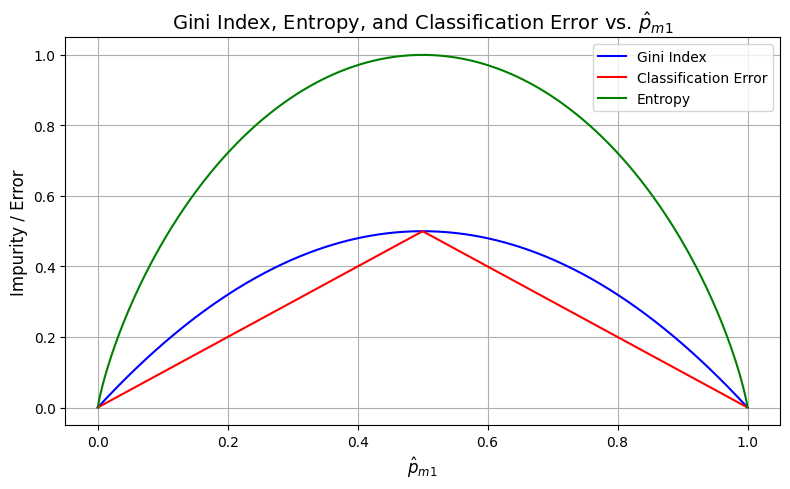

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(p, gini, label='Gini Index', color='blue')
plt.plot(p, classification_error, label='Classification Error', color='red')
plt.plot(p, entropy, label='Entropy', color='green')
plt.xlabel(r'$\hat{p}_{m1}$', fontsize=12)
plt.ylabel('Impurity / Error', fontsize=12)
plt.title('Gini Index, Entropy, and Classification Error vs. $\hat{p}_{m1}$', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR").data


In [11]:
carseats = pd.get_dummies(carseats, drop_first=True)

In [12]:
X = carseats.drop(columns='Sales')
y = carseats['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

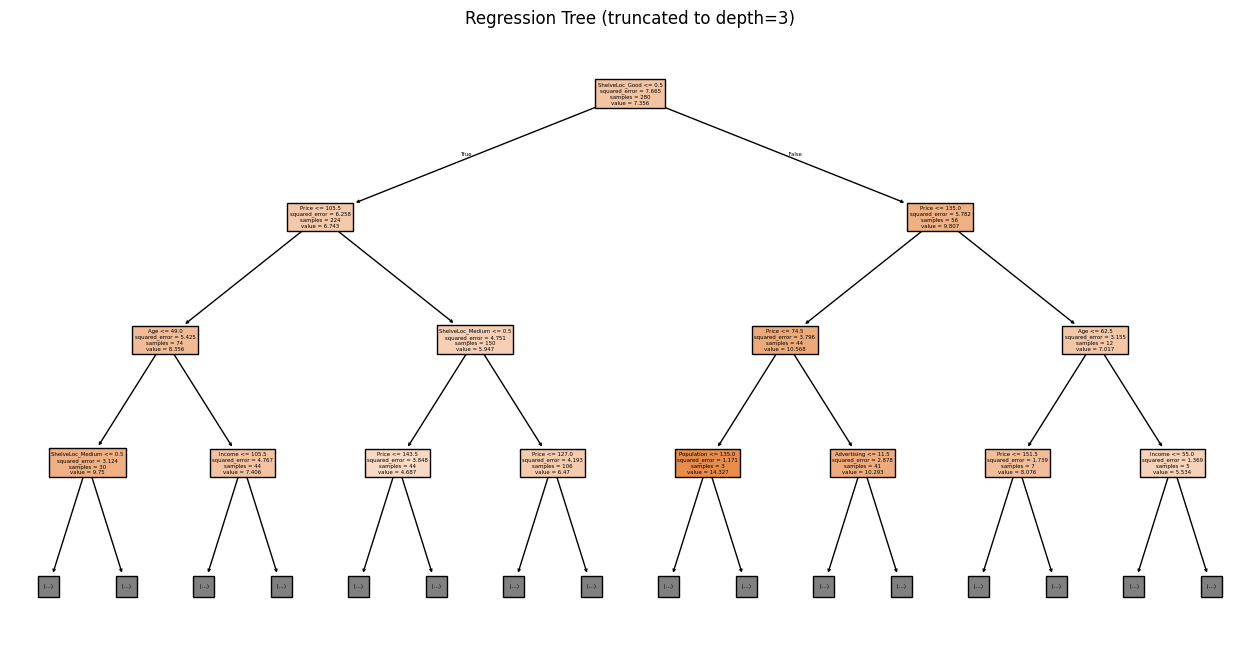

In [14]:
plt.figure(figsize=(16, 8))
plot_tree(tree_reg, feature_names=X.columns, filled=True, max_depth=3)
plt.title("Regression Tree (truncated to depth=3)")
plt.show()

In [15]:
y_pred = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred)
print(f"Test MSE (Regression Tree): {mse_tree:.3f}")

Test MSE (Regression Tree): 4.805


In [16]:
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

In [17]:
trees = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    trees.append(reg)

In [18]:
cv_scores = [np.mean(-cross_val_score(t, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
             for t in trees]

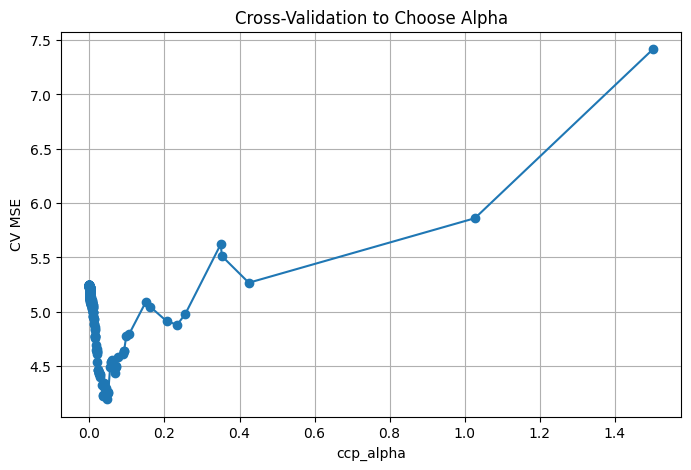

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(ccp_alphas, cv_scores, marker='o')
plt.xlabel("ccp_alpha")
plt.ylabel("CV MSE")
plt.title("Cross-Validation to Choose Alpha")
plt.grid(True)
plt.show()

In [20]:
best_alpha = ccp_alphas[np.argmin(cv_scores)]
tree_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
tree_pruned.fit(X_train, y_train)
y_pred_pruned = tree_pruned.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Test MSE (Pruned Tree): {mse_pruned:.3f}")

Test MSE (Pruned Tree): 4.552


In [22]:
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=500,
    random_state=42,
    oob_score=True
)
bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=500,
                 oob_score=True, random_state=42)

In [23]:
y_pred_bag = bagging_model.predict(X_test)
mse_bag = mean_squared_error(y_test, y_pred_bag)
print(f"Test MSE (Bagging): {mse_bag:.3f}")

Test MSE (Bagging): 2.464


In [24]:
importances_bag = np.mean([
    tree.feature_importances_ for tree in bagging_model.estimators_
], axis=0)

In [25]:
feat_imp_bag = pd.Series(importances_bag, index=X.columns).sort_values(ascending=False)
print("\nBagging Feature Importances:\n", feat_imp_bag.head())


Bagging Feature Importances:
 Price             0.323418
ShelveLoc_Good    0.191917
Age               0.119317
CompPrice         0.106141
Advertising       0.071705
dtype: float64


In [26]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Test MSE (Random Forest): {mse_rf:.3f}")

Test MSE (Random Forest): 2.483


In [27]:
feat_imp_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:\n", feat_imp_rf.head())


Random Forest Feature Importances:
 Price             0.323414
ShelveLoc_Good    0.191970
Age               0.119546
CompPrice         0.106290
Advertising       0.071229
dtype: float64


In [28]:
errors = []
for m in range(1, X.shape[1] + 1):
    rf = RandomForestRegressor(n_estimators=500, max_features=m, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    errors.append(mean_squared_error(y_test, y_pred))

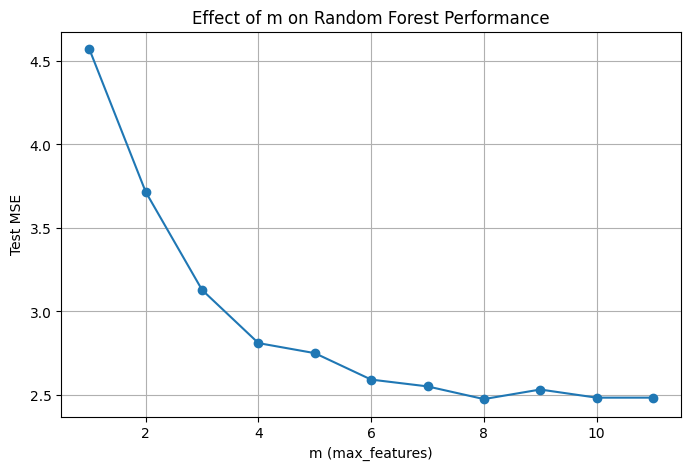

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, X.shape[1] + 1), errors, marker='o')
plt.xlabel("m (max_features)")
plt.ylabel("Test MSE")
plt.title("Effect of m on Random Forest Performance")
plt.grid(True)
plt.show()

In [39]:
%pip install pymc-bart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.1 MB/s eta 0:00:00


In [47]:
from pymc_bart import BART
import pymc as pm

with pm.Model() as model:
    bart = BART(name='bart', X=X_train, Y=y_train)

y_pred_bart = bart. .predict(X_test.values)
mse_bart = mean_squared_error(y_test, y_pred_bart)
print(f"Test MSE (BART): {mse_bart:.3f}")

AttributeError: 'TensorVariable' object has no attribute 'predict'

In [48]:
oj = sm.datasets.get_rdataset("OJ", "ISLR").data

In [49]:
oj['Purchase'] = oj['Purchase'].astype('category')
oj = pd.get_dummies(oj, drop_first=True)

In [51]:
oj.head()

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Purchase_MM,Store7_Yes
0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,False,False
1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,False,False
2,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,False,False
3,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,True,False
4,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,False,True


In [52]:
train_df, test_df = train_test_split(oj, train_size=800, random_state=42)
X_train = train_df.drop(columns=['Purchase_MM'])
y_train = train_df['Purchase_MM']

In [53]:
X_test = test_df.drop(columns=['Purchase_MM'])
y_test = test_df['Purchase_MM']

In [56]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [57]:
train_preds = tree_clf.predict(X_train)
train_error = 1 - accuracy_score(y_train, train_preds)
print(f"Training Error Rate: {train_error:.3f}")

Training Error Rate: 0.007


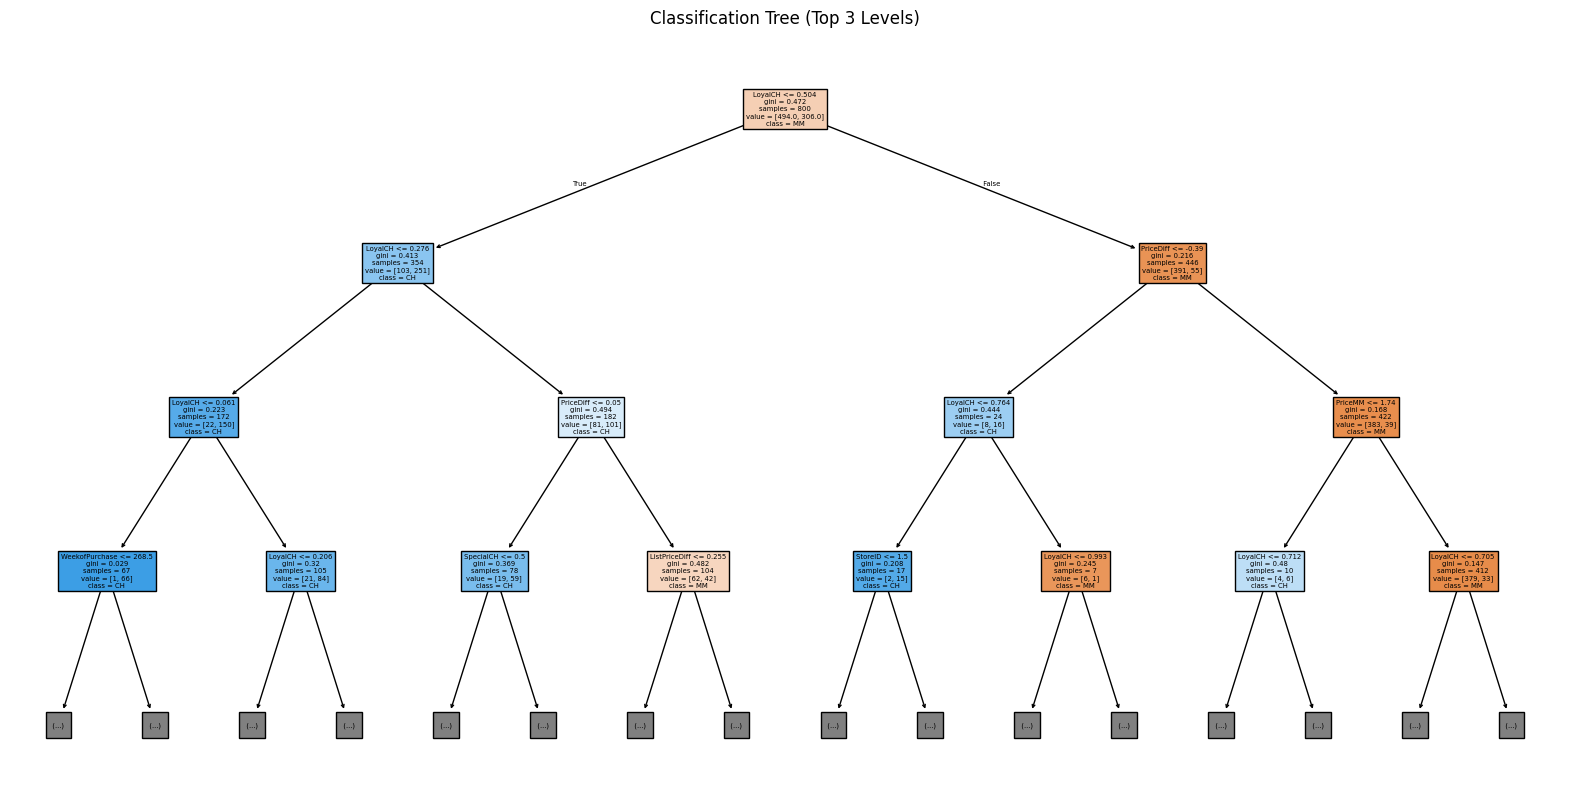

In [58]:
plt.figure(figsize=(20, 10))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names=["MM", "CH"], max_depth=3)
plt.title("Classification Tree (Top 3 Levels)")
plt.show()

In [59]:
n_leaves = tree_clf.get_n_leaves()
print(f"Number of Terminal Nodes: {n_leaves}")

Number of Terminal Nodes: 163


In [60]:
tree_text = export_text(tree_clf, feature_names=list(X_train.columns))
print(tree_text)

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: True
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- PriceDiff <= 0.29
|   |   |   |   |   |--- class: True
|   |   |   |   |--- PriceDiff >  0.29
|   |   |   |   |   |--- class: False
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- STORE <= 0.50
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.12
|   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.12
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |   |--- L

In [61]:
test_preds = tree_clf.predict(X_test)
cm = confusion_matrix(y_test, test_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[122  37]
 [ 38  73]]


In [62]:
test_error = 1 - accuracy_score(y_test, test_preds)
print(f"Test Error Rate: {test_error:.3f}")

Test Error Rate: 0.278


In [63]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

In [64]:
trees = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)

In [65]:
cv_scores = [np.mean(cross_val_score(t, X_train, y_train, cv=10)) for t in trees]

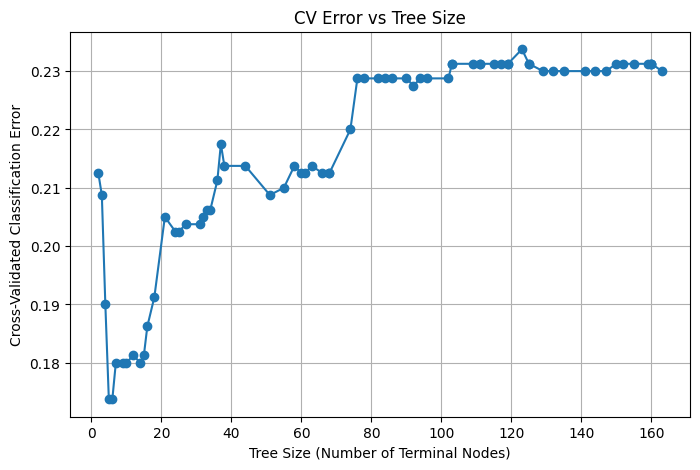

In [66]:
plt.figure(figsize=(8, 5))
plt.plot([t.get_n_leaves() for t in trees], 1 - np.array(cv_scores), marker='o')
plt.xlabel("Tree Size (Number of Terminal Nodes)")
plt.ylabel("Cross-Validated Classification Error")
plt.title("CV Error vs Tree Size")
plt.grid(True)
plt.show()

In [67]:
optimal_index = np.argmax(cv_scores)
optimal_tree_size = trees[optimal_index].get_n_leaves()
print(f"Optimal Tree Size: {optimal_tree_size}")

Optimal Tree Size: 6


In [68]:
if optimal_tree_size < tree_clf.get_n_leaves():
    pruned_tree = trees[optimal_index]
    print("Using optimal pruned tree.")
else:
    # Manually prune to 5 leaves
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[np.argmin([abs(t.get_n_leaves()-5) for t in trees])])
    pruned_tree.fit(X_train, y_train)
    print("No pruning recommended by CV. Using tree with 5 terminal nodes.")

Using optimal pruned tree.


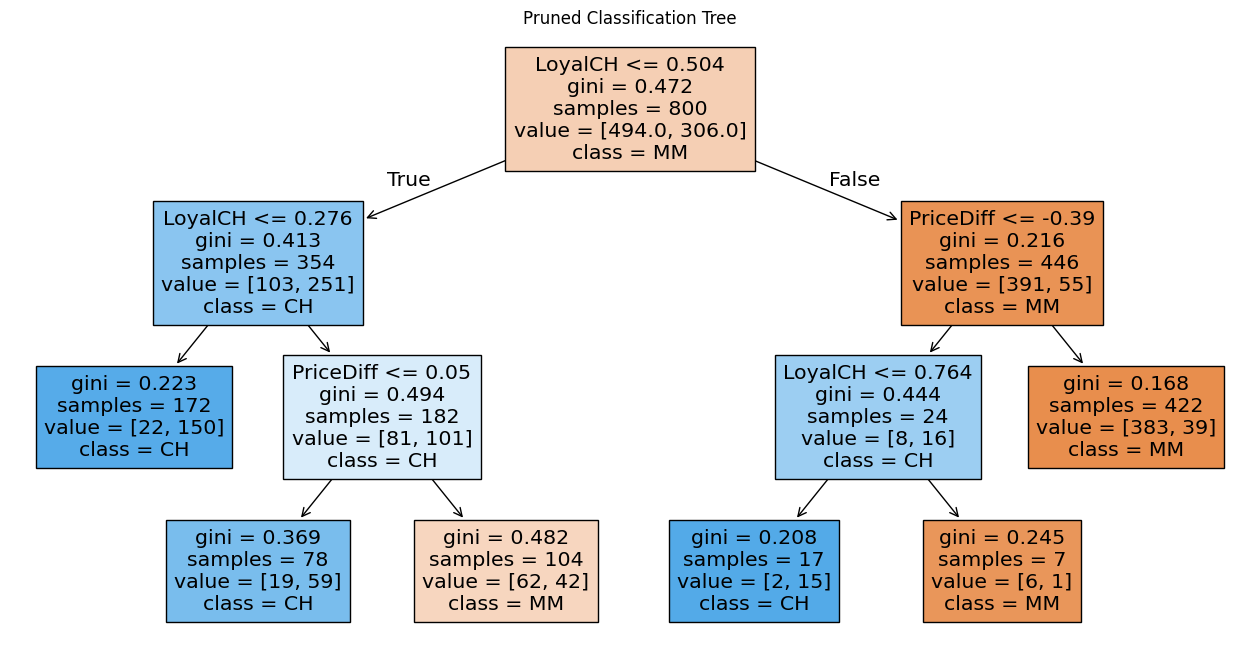

In [69]:
plt.figure(figsize=(16, 8))
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns, class_names=["MM", "CH"])
plt.title("Pruned Classification Tree")
plt.show()

In [70]:
train_error_unpruned = 1 - accuracy_score(y_train, tree_clf.predict(X_train))
train_error_pruned = 1 - accuracy_score(y_train, pruned_tree.predict(X_train))

print(f"Training Error (Unpruned): {train_error_unpruned:.3f}")
print(f"Training Error (Pruned):   {train_error_pruned:.3f}")

Training Error (Unpruned): 0.007
Training Error (Pruned):   0.156


In [71]:
test_error_unpruned = 1 - accuracy_score(y_test, tree_clf.predict(X_test))
test_error_pruned = 1 - accuracy_score(y_test, pruned_tree.predict(X_test))

print(f"Test Error (Unpruned): {test_error_unpruned:.3f}")
print(f"Test Error (Pruned):   {test_error_pruned:.3f}")

Test Error (Unpruned): 0.278
Test Error (Pruned):   0.193
